# Import relevant libraries

In [1]:
import os
import json
import matplotlib.pyplot as plt 
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
from pyproj import CRS
from shapely.geometry import Point
import contextily as ctx

# Load UK shape file

In [2]:
# load geodata
uk = gpd.read_file("http://martinjc.github.io/UK-GeoJSON/json/eng/topo_lad.json")

# set Coordinate Reference Systems
crs_4326 = CRS("epsg:4326")
crs_4326
uk.crs = crs_4326

In [3]:
uk.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
uk

,id,LAD13CD,LAD13CDO,LAD13NM,LAD13NMW,geometry
0,E06000001,E06000001,00EB,Hartlepool,None,"MULTIPOLYGON (((-1.24244 54.72219, -1.24162 54..."
1,E06000002,E06000002,00EC,Middlesbrough,None,"MULTIPOLYGON (((-1.19744 54.58184, -1.19416 54..."
2,E06000003,E06000003,00EE,Redcar and Cleveland,None,"MULTIPOLYGON (((-1.20071 54.57768, -1.19989 54..."
3,E06000004,E06000004,00EF,Stockton-on-Tees,None,"MULTIPOLYGON (((-1.28171 54.56460, -1.27762 54..."
4,E06000005,E06000005,00EH,Darlington,None,"POLYGON ((-1.43800 54.59493, -1.43554 54.59552..."
...,...,...,...,...,...,...
321,E09000029,E09000029,00BF,Sutton,None,"POLYGON ((-0.13456 51.39073, -0.13292 51.39013..."
322,E09000030,E09000030,00BG,Tower Hamlets,None,"POLYGON ((-0.01673 51.54356, -0.01591 51.54237..."
323,E09000031,E09000031,00BH,Waltham Forest,None,"POLYGON ((0.02172 51.62861, 0.02091 51.62920, ..."
324,E09000032,E09000032,00BJ,Wandsworth,None,"POLYGON ((-0.14028 51.41927, -0.14438 51.41749..."


In [5]:
# select only relevant columns
uk = uk[['LAD13NM', 'geometry']]
# rename column
uk.rename(columns = {'LAD13NM': 'district'}, inplace = True)

/home/voravich/anaconda3/envs/smm635/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [6]:
uk.head()

,district,geometry
0,Hartlepool,"MULTIPOLYGON (((-1.24244 54.72219, -1.24162 54..."
1,Middlesbrough,"MULTIPOLYGON (((-1.19744 54.58184, -1.19416 54..."
2,Redcar and Cleveland,"MULTIPOLYGON (((-1.20071 54.57768, -1.19989 54..."
3,Stockton-on-Tees,"MULTIPOLYGON (((-1.28171 54.56460, -1.27762 54..."
4,Darlington,"POLYGON ((-1.43800 54.59493, -1.43554 54.59552..."


<AxesSubplot:>

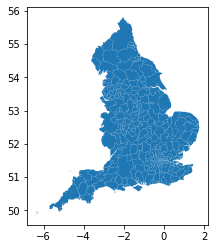

In [7]:
uk.plot()

# Load tech roundabout data

In [8]:
# set file path
base_path = '../..'
file_path = os.path.join(base_path, 'datasets', 'tech_roundabout_coordinates.csv')

# load data
tech_roundabout = pd.read_csv(file_path)

In [9]:
sum(tech_roundabout['RegAddress.PostCode'] == 'EC2N 1HQ')

251

In [10]:
# set-up coordinates
tech_roundabout_coordinates = tech_roundabout[['CompanyName', 'latitude', 'longitude']]

tech_roundabout_coordinates = gpd.GeoDataFrame(
    tech_roundabout_coordinates.drop(['latitude','longitude'], axis = 1),
    geometry=[Point(xy) for xy in zip(tech_roundabout_coordinates.longitude,
                                      tech_roundabout_coordinates.latitude)])

In [11]:
# project to epsg:4326
tech_roundabout_coordinates.crs = crs_4326

In [12]:
tech_roundabout_coordinates.head()

,CompanyName,geometry
0,!BIG IMPACT GRAPHICS LIMITED,POINT (-0.07869 51.52702)
1,"""K"" LINE (EUROPE) LIMITED",POINT (-0.09736 51.51757)
2,"""K"" LINE BULK SHIPPING (UK) LIMITED",POINT (-0.09736 51.51757)
3,"""K"" LINE HOLDING (EUROPE) LIMITED",POINT (-0.09736 51.51757)
4,"""K"" LINE LNG SHIPPING (UK) LIMITED",POINT (-0.09736 51.51757)


# Spatial join

In [13]:
# get district
tech_roundabout_full = gpd.sjoin(tech_roundabout_coordinates, uk,
                                 how = 'left', op = 'within').drop(columns = 'index_right')

In [14]:
# remove data points that are not in the uk --- bug when request for coordinate
tech_roundabout_full = tech_roundabout_full[~tech_roundabout_full.district.isna()]

In [15]:
# remove irrelevant data point --- postcode provided cannot be found on Google Map
tech_roundabout_full = tech_roundabout_full[~tech_roundabout_full['district'].isin(['Brentwood', 'Sheffield'])]

In [16]:
tech_roundabout_full.head()

,CompanyName,geometry,district
0,!BIG IMPACT GRAPHICS LIMITED,POINT (-0.07869 51.52702),Hackney
1,"""K"" LINE (EUROPE) LIMITED",POINT (-0.09736 51.51757),City of London
2,"""K"" LINE BULK SHIPPING (UK) LIMITED",POINT (-0.09736 51.51757),City of London
3,"""K"" LINE HOLDING (EUROPE) LIMITED",POINT (-0.09736 51.51757),City of London
4,"""K"" LINE LNG SHIPPING (UK) LIMITED",POINT (-0.09736 51.51757),City of London


# Visualize data

In [17]:
tech_roundabout_district = uk[uk['district'].isin(tech_roundabout_full['district'].unique())]

In [18]:
tech_roundabout_district

,district,geometry
293,City of London,"POLYGON ((-0.08546 51.52037, -0.08301 51.51978..."
299,Camden,"POLYGON ((-0.14274 51.56914, -0.14028 51.56438..."
304,Hackney,"POLYGON ((-0.06092 51.57806, -0.05846 51.57270..."
311,Islington,"POLYGON ((-0.10428 51.56497, -0.09856 51.56081..."
322,Tower Hamlets,"POLYGON ((-0.01673 51.54356, -0.01591 51.54237..."


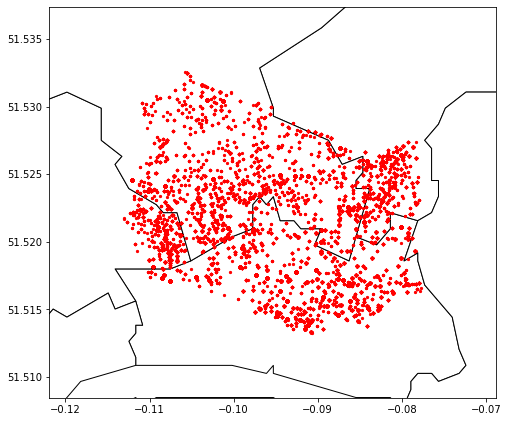

In [40]:
fig, ax = plt.subplots(figsize = (8, 8))

ax.set_aspect('equal')
uk.plot(ax=ax, color='white', edgecolor='black')
tech_roundabout_full.plot(ax=ax, marker='o', color='red', markersize=5)

# set boundary
xmin, ymin, xmax, ymax = tech_roundabout_full.total_bounds
x_adj = abs((xmax - xmin) / 4)
y_adj = abs((ymax - ymin) / 4)
xlim = (xmin - x_adj, xmax + x_adj)
ylim = (ymin - y_adj, ymax + y_adj)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

In [41]:
tech_roundabout

,CompanyName,RegAddress.PostCode,RegAddress.PostTown,latitude,longitude
0,!BIG IMPACT GRAPHICS LIMITED,EC1V 9LT,LONDON,51.527024,-0.078695
1,"""K"" LINE (EUROPE) LIMITED",EC1A 4HD,LONDON,51.517573,-0.097357
2,"""K"" LINE BULK SHIPPING (UK) LIMITED",EC1A 4HD,LONDON,51.517573,-0.097357
3,"""K"" LINE HOLDING (EUROPE) LIMITED",EC1A 4HD,LONDON,51.517573,-0.097357
4,"""K"" LINE LNG SHIPPING (UK) LIMITED",EC1A 4HD,LONDON,51.517573,-0.097357
...,...,...,...,...,...
97964,ÉCLAT CENTURY SERVICES LIMITED,EC1V 2NX,LONDON,51.527246,-0.088808
97965,ÉLEVAGE JOLIVET LTD,EC1V 2NX,LONDON,51.527246,-0.088808
97966,ÜVIEW LIMITED,EC2A 4NE,LONDON,51.525590,-0.083715
97967,‘ADORE BOURNEMOUTH LTD,EC2A 3AR,LONDON,51.526394,-0.080132
